# Imports

In [108]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Add, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

from nltk.translate.bleu_score import corpus_bleu

In [3]:
from dataset.utils import load_coco, load_image, print_progress_bar
from image_model.topic_layers import load_topic_model, load_feature_model

# Load Data

In [4]:
# Folder containing the datset
data_dir = 'dataset/'

In [5]:
train_data, val_data, test_data, category_id, id_category = load_coco(
    os.path.join(data_dir, 'coco_raw.pickle'), 'captions'
)

In [6]:
train_images, train_captions = train_data  # Load training data
val_images, val_captions = val_data  # Load validation data
test_images, test_captions = test_data  # Load test data

In [7]:
num_classes = len(id_category)
num_classes

80

In [8]:
num_images_train = len(train_images)
num_images_train

19324

In [9]:
num_images_val = len(val_images)
num_images_val

2415

### Display a sample image

A long line of skiers on a steep snow covered hill.
A trail of people on skis in the snow.
A group of people on skis on a snow covered slope.
A group of people skiing in a line down a trail.
Many people in the snow on skis by some trees.


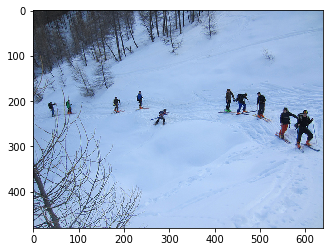

In [10]:
# display image
idx = 10

for caption in train_captions[idx]:
    print(caption)

plt.imshow(load_image(os.path.join(data_dir, train_images[idx])))
plt.show()

# Load Pre-Trained Image Model

In [11]:
# Load the pre-trained topic model
weights_path = os.path.join(os.getcwd(), 'topic_extraction', 'weights', 'checkpoint.keras')
topic_model = load_topic_model(num_classes, weights_path)
topic_model.summary()

Error trying to load weights.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 4096)              139570240 
_________________________________________________________________
dense (Dense)                (None, 80)                327760    
Total params: 139,898,000
Trainable params: 327,760
Non-trainable params: 139,570,240
_________________________________________________________________


In [12]:
# Load the pre-trained feature extractor model
feature_model = load_feature_model()

### Process Images

In [13]:
def process_images(topic_model, feature_model, data_dir, filenames, batch_size):
    """
    Process all the given files in the given data_dir using the
    pre-trained topic-model as well as the feature-model and return
    their transfer-values.
    
    The images are processed in batches to save
    memory and improve efficiency.
    """
    
    num_images = len(filenames)
    img_size = K.int_shape(topic_model.input)[1:3]    # Expected input size of the pre-trained network

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float32)

    # Pre-allocate output-array for transfer-values.
    topic_transfer_values = np.zeros(
        shape=(num_images,) + K.int_shape(topic_model.output)[1:],
        dtype=np.float32
    )
    feature_transfer_values = np.zeros(
        shape=(num_images, K.int_shape(feature_model.output)[1]),
        dtype=np.float32
    )

    start_index = 0
    print_progress_bar(start_index, num_images)  # Initial call to print 0% progress

    while start_index < num_images:
        end_index = start_index + batch_size
        if end_index > num_images:
            end_index = num_images
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)
            img = load_image(path, size=img_size)
            image_batch[i] = img

        # Use the pre-trained models to process the image.
        topic_transfer_values_batch = topic_model.predict(
            image_batch[0:current_batch_size]
        )
        feature_transfer_values_batch = feature_model.predict(
            image_batch[0:current_batch_size]
        )

        # Save the transfer-values in the pre-allocated arrays.
        topic_transfer_values[start_index:end_index] = topic_transfer_values_batch[0:current_batch_size]
        feature_transfer_values[start_index:end_index] = feature_transfer_values_batch[0:current_batch_size]

        start_index = end_index
        print_progress_bar(start_index, num_images)  # Update Progress Bar

    print()
    return topic_transfer_values, feature_transfer_values

In [14]:
def process_data(topic_model, feature_model, data_dir, data_type, filenames, captions, batch_size):
    print('Processing {0} images in {1}-set ...'.format(len(filenames), data_type))

    # Path for the cache-file.
    cache_path_dir = os.path.join(data_dir, 'processed_caption_data')
    topic_cache_path = os.path.join(
        cache_path_dir, 'topic_transfer_values_{}.pkl'.format(data_type)
    )
    feature_cache_path = os.path.join(
        cache_path_dir, 'feature_transfer_values_{}.pkl'.format(data_type)
    )
    images_cache_path = os.path.join(
        cache_path_dir, 'images_{}.pkl'.format(data_type)
    )
    captions_cache_path = os.path.join(
        cache_path_dir, 'captions_{}.pkl'.format(data_type)
    )
    
    # Check if directory to store processed data exists
    if not os.path.exists(cache_path_dir):
        print('Directory created:', cache_path_dir)
        os.mkdir(cache_path_dir)

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    topic_path_exists = os.path.exists(topic_cache_path)
    feature_path_exists = os.path.exists(feature_cache_path)
    image_path_exists = os.path.exists(images_cache_path)
    caption_path_exists = os.path.exists(captions_cache_path)
    if topic_path_exists and feature_path_exists and image_path_exists and caption_path_exists:
        with open(topic_cache_path, mode='rb') as file:
            topic_obj = pickle.load(file)
        with open(feature_cache_path, mode='rb') as file:
            feature_obj = pickle.load(file)
        with open(images_cache_path, mode='rb') as file:
            images = pickle.load(file)
        with open(captions_cache_path, mode='rb') as file:
            captions = pickle.load(file)
        print("Data loaded from cache-file.")
    else:
        topic_obj, feature_obj = process_images(
            topic_model, feature_model, data_dir, filenames, batch_size
        )
        with open(topic_cache_path, mode='wb') as file:
            pickle.dump(topic_obj, file)
        with open(feature_cache_path, mode='wb') as file:
            pickle.dump(feature_obj, file)
        with open(images_cache_path, mode='wb') as file:
            pickle.dump(filenames, file)
        with open(captions_cache_path, mode='wb') as file:
            pickle.dump(captions, file)
        print("Data saved to cache-file.")

    return topic_obj, feature_obj, images, captions

In [15]:
process_batch_size = 128

In [16]:
%%time
# Training Data
topic_transfer_values_train, feature_transfer_values_train, images_train, captions_train = process_data(
    topic_model, feature_model, data_dir, 'train', train_images, train_captions, process_batch_size
)
print("topic shape:", topic_transfer_values_train.shape)
print("feature shape:", feature_transfer_values_train.shape)

Processing 19324 images in train-set ...
Data loaded from cache-file.
topic shape: (19324, 80)
feature shape: (19324, 4096)
CPU times: user 112 ms, sys: 390 ms, total: 502 ms
Wall time: 500 ms


In [17]:
%%time
# Validation Data
topic_transfer_values_val, feature_transfer_values_val, images_val, captions_val = process_data(
    topic_model, feature_model, data_dir, 'val', val_images, val_captions, process_batch_size
)
print("topic shape:", topic_transfer_values_val.shape)
print("feature shape:", feature_transfer_values_val.shape)

Processing 2415 images in val-set ...
Data loaded from cache-file.
topic shape: (2415, 80)
feature shape: (2415, 4096)
CPU times: user 11.5 ms, sys: 52 ms, total: 63.5 ms
Wall time: 60.7 ms


In [18]:
%%time
# Test Data
topic_transfer_values_test, feature_transfer_values_test, images_test, captions_test = process_data(
    topic_model, feature_model, data_dir, 'test', test_images, test_captions, process_batch_size
)
print("topic shape:", topic_transfer_values_test.shape)
print("feature shape:", feature_transfer_values_test.shape)

Processing 2417 images in test-set ...
Data loaded from cache-file.
topic shape: (2417, 80)
feature shape: (2417, 4096)
CPU times: user 17.2 ms, sys: 48.6 ms, total: 65.8 ms
Wall time: 63.5 ms


# Tokenizer

In [19]:
mark_start = 'startseq'
mark_end = 'endseq'

In [20]:
def mark_captions(captions_list):
    """ Mark all the captions with the start and the end marker """
    captions_marked = [
        [' '.join([mark_start, caption, mark_end]) for caption in captions] for captions in captions_list
    ]
    
    return captions_marked

In [21]:
captions_train_marked = mark_captions(captions_train)  # training
captions_val_marked = mark_captions(captions_val)  # validation
print('Marked captions:')
captions_train_marked[0]

Marked captions:


['startseq A large group of people flying kites in a large open field. endseq',
 'startseq People fly kites at a festival on a sunny day in a field. endseq',
 'startseq a number of kites flying over a field endseq',
 'startseq A group of people in a field flying their kites. endseq',
 'startseq A group of people are flying kites in a field. endseq']

In [22]:
def flatten(captions_list):
    """ Flatten all the captions into a single list """
    caption_list = [caption
                    for caption_list in captions_list
                    for caption in caption_list]
    
    return caption_list

In [23]:
captions_train_flat = flatten(captions_train_marked)

Create the tokenizer

In [24]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_train_flat)

CPU times: user 1.85 s, sys: 15 ms, total: 1.86 s
Wall time: 1.86 s


In [25]:
# Get integer token for the start marker
token_start = tokenizer.word_index[mark_start]
token_start

2

In [26]:
# Get integer token for the end marker
token_end = tokenizer.word_index[mark_end]
token_end

3

In [27]:
# Numbers of words in the vocabulary
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8573

In [28]:
# Max length of each caption
max_tokens = 16

# Data Generator

In [29]:
def create_sequences(tokenizer, max_length, topic_transfer_value, feature_transfer_value, caption):
    """ Create sequences of topic_values, feature_values, input sequence and output sequence for an image """
    topic_values, feature_values = [], []
    input_captions, output_captions = [], []
    integer_sequence = tokenizer.texts_to_sequences([caption])[0]  # encode the sequence
    
    for idx in range(1, len(integer_sequence)):
        in_seq, out_seq = integer_sequence[:idx], integer_sequence[idx]  # split into input and output pair
        in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post', truncating='post')[0]  # pad input sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  # encode output sequence
        
        # store
        topic_values.append(topic_transfer_value)
        feature_values.append(feature_transfer_value)
        input_captions.append(in_seq)
        output_captions.append(out_seq)
        
    return topic_values, feature_values, input_captions, output_captions

In [30]:
def batch_generator(topic_transfer_values, feature_transfer_values, captions_list, tokenizer, num_images, batch_size, max_length, vocab_size):
    """
    Generator function for creating random batches of training-data.
    
    It selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the dataset.
        indices = np.random.randint(num_images, size=batch_size)
        
        # For a batch of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random
        topic_values, feature_values = [], []
        input_captions, output_captions = [], []
        for idx in indices:
            topic_value, feature_value, input_caption, output_caption = create_sequences(
                tokenizer,
                max_length,
                topic_transfer_values[idx],
                feature_transfer_values[idx],
                np.random.choice(captions_list[idx])
            )
            topic_values.extend(topic_value)
            feature_values.extend(feature_value)
            input_captions.extend(input_caption)
            output_captions.extend(output_caption)

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = {
            'caption_input': np.array(input_captions),
            'topic_input': np.array(topic_values),
            'feature_input': np.array(feature_values)
        }

        # Dict for the output-data.
        y_data = {
            'caption_output': np.array(output_captions)
        }
        
        yield (x_data, y_data)

In [31]:
batch_size = 128

In [32]:
generator_train = batch_generator(  # training
    topic_transfer_values_train,
    feature_transfer_values_train,
    captions_train_marked,
    tokenizer,
    num_images_train,
    batch_size,
    max_tokens,
    vocab_size
)

generator_val = batch_generator(  # validation
    topic_transfer_values_val,
    feature_transfer_values_val,
    captions_val_marked,
    tokenizer,
    num_images_val,
    batch_size,
    max_tokens,
    vocab_size
)

batch = next(generator_train)
batch_x = batch[0]
batch_y = batch[1]

In [33]:
# Example of the topic-transfer-values for the first image in the batch
batch_x['topic_input'][0]

array([0.33067694, 0.44283077, 0.60610276, 0.8512371 , 0.09282196,
       0.69093376, 0.78271437, 0.86746967, 0.47757018, 0.5620481 ,
       0.23805682, 0.0732512 , 0.74025005, 0.15102893, 0.13534485,
       0.48045743, 0.6721443 , 0.42655063, 0.37997025, 0.65953976,
       0.8457677 , 0.2048258 , 0.61755913, 0.48838237, 0.40232   ,
       0.347524  , 0.60400754, 0.22722217, 0.5271655 , 0.85840917,
       0.49883553, 0.553186  , 0.42113796, 0.22537433, 0.8441003 ,
       0.7132459 , 0.60526735, 0.6238645 , 0.22962366, 0.56881785,
       0.15079466, 0.5037232 , 0.51952326, 0.6305131 , 0.48462653,
       0.61854464, 0.8074544 , 0.23143803, 0.29117158, 0.37225538,
       0.4907529 , 0.7105217 , 0.10852516, 0.25423604, 0.33357978,
       0.81101733, 0.630706  , 0.33537734, 0.48117876, 0.52454156,
       0.07818767, 0.6846683 , 0.51680064, 0.71389896, 0.2528341 ,
       0.19904186, 0.58013284, 0.40507707, 0.14483015, 0.8371884 ,
       0.5891502 , 0.89065856, 0.711671  , 0.505697  , 0.34382

In [34]:
# Example of the feature-transfer-values for the first image in the batch
batch_x['feature_input'][0]

array([0.6691664 , 0.        , 0.68380845, ..., 0.        , 0.82177734,
       0.13278079], dtype=float32)

In [35]:
# Example of the token-sequence for the first image in the batch
# This is the input to the decoder-part of the neural network
batch_x['caption_input'][0]

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [36]:
# This is the token-sequence for the output of the decoder
# Note how it is the same as the sequence above, except it is shifted one time-step
batch_y['caption_output'][0]

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [37]:
# Shape of the output
batch_y['caption_output'].shape

(1482, 8573)

## Steps Per Epoch

In [38]:
def calculate_steps_per_epoch(captions_list, batch_size):
    # Number of captions for each image
    num_captions = [len(captions) for captions in captions_list]
    
    # Total number of captions
    total_num_captions = np.sum(num_captions)
    
    return int(total_num_captions / batch_size)

In [39]:
steps_per_epoch_train = calculate_steps_per_epoch(captions_train_marked, batch_size)
steps_per_epoch_train

755

In [40]:
steps_per_epoch_val = calculate_steps_per_epoch(captions_val_marked, batch_size)
steps_per_epoch_val

94

# Create Model

### Create pre-trained Embedding Layer

In [41]:
def read_glove_vecs(glove_file):
    print('Creating word to vec map...')
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float32)
    print('Done!')
    return word_to_vec_map

In [42]:
# load embeddings
word_to_vec_map = read_glove_vecs('{}/glove.6B.300d.txt'.format(data_dir))

Creating word to vec map...
Done!


In [43]:
# assign embeddings values to custom tokens
size = word_to_vec_map['unk'].shape

word_to_vec_map[mark_start] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map[mark_end] = np.random.uniform(low=-1.0, high=1.0, size=size)

In [44]:
def create_embedding_layer(word_to_index, word_to_vec_map, num_words):
    """ Create a Keras Embedding() layer and load in pre-trained GloVe 300-dimensional vectors
        @params:
        :word_to_index -- dictionary containing the each word mapped to its index
        :word_to_vec_map -- dictionary mapping words to their GloVe vector representation
        :num_words -- number of words in the vocabulary
        
        @return:
        :decoder_embedding -- pretrained layer Keras instance
    """
    
    vocabulary_length = num_words + 1  # adding 1 to fit Keras embedding (requirement)
    embedding_dimensions = word_to_vec_map['unk'].shape[0]  # define dimensionality of GloVe word vectors (= 300)
    
    embedding_matrix = np.zeros((vocabulary_length, embedding_dimensions))  # initialize with zeros
    for word, index in word_to_index.items():
        try:
            embedding_matrix[index, :] = word_to_vec_map[word]
        except KeyError:
            embedding_matrix[index, :] = word_to_vec_map['unk']
    
    # we don't want the embeddings to be updated, thus trainable parameter is set to False
    decoder_embedding = Embedding(
        input_dim=vocabulary_length,
        output_dim=embedding_dimensions,
        trainable=False,
        name='decoder_embedding'
    )
    decoder_embedding.build((None,))
    decoder_embedding.set_weights([embedding_matrix])  # with this the layer is now pretrained
    
    return decoder_embedding

### Define some global values

In [45]:
# Internal state-sizes of LSTMs
state_size = 256

In [ ]:
K.clear_session()

## Encode Images

In [46]:
# Input layer to receive the predictions from the feature model
feature_input = Input(
    shape=K.int_shape(feature_model.output)[1:], name='feature_input'
)

In [47]:
# Reshape feature transfer values
image_model_output = Dense(state_size, activation='relu', name='image_model_output')(feature_input)
image_model_output

<tf.Tensor 'image_model_output/Relu:0' shape=(?, 256) dtype=float32>

## Encode Captions

### Create model to encode captions

Define layers

In [48]:
# This inputs topic-transfer-values to the LSTM
topic_input = Input(
    shape=K.int_shape(topic_model.output)[1:], name='topic_input'
)

In [49]:
# Input for token-sequences to the decoder
# Using 'None' in the shape means that the token-sequences can have arbitrary lengths
caption_input = Input(shape=(max_tokens,), name='caption_input')

In [50]:
# Embedding-layer which converts sequences of integer-tokens to sequences of vectors
caption_embedding = create_embedding_layer(tokenizer.word_index, word_to_vec_map, vocab_size)

In [51]:
# The LSTM layer for the input captions
caption_lstm = LSTM(state_size, name='caption_lstm')

Connect the layers

In [52]:
# Reshape the topic transfer values to 3D tensor in-order to feed it to the LSTM
topic_input_reshaped = Reshape(
    target_shape=(K.int_shape(topic_input)[1:] + (1,))
)(topic_input)

In [53]:
# Feed topic to LSTM
_, initial_state_h0, initial_state_c0 = LSTM(
    state_size, return_state=True, name='topic_lstm'
)(topic_input_reshaped)

topic_lstm_states = [initial_state_h0, initial_state_c0]

In [54]:
net = caption_input  # Start the decoder-network with its input-layer
net = caption_embedding(net)  # Connect the embedding-layer
caption_model_output = caption_lstm(net, initial_state=topic_lstm_states) # Connect the caption LSTM layer
caption_model_output

<tf.Tensor 'caption_lstm/TensorArrayReadV3:0' shape=(?, 256) dtype=float32>

## Merge the image and the caption model

In [55]:
# Concat the outputs of both the models
merge_net = Add()([image_model_output, caption_model_output])

In [56]:
merge_net = Dense(state_size, activation='relu')(merge_net)
outputs = Dense(vocab_size, activation='softmax', name='caption_output')(merge_net)
outputs

<tf.Tensor 'caption_output/Softmax:0' shape=(?, 8573) dtype=float32>

# Create the Training Model

In [57]:
model = Model(
    inputs=[feature_input, topic_input, caption_input],
    outputs=outputs
)

In [58]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
topic_input (InputLayer)        (None, 80)           0                                            
__________________________________________________________________________________________________
caption_input (InputLayer)      (None, 16)           0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 80, 1)        0           topic_input[0][0]                
__________________________________________________________________________________________________
feature_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_em

## Compile the Training Model

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Callback Functions

In [60]:
path_checkpoint = 'weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
callback_checkpoint = ModelCheckpoint(
    filepath=path_checkpoint,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [61]:
callback_tensorboard = TensorBoard(
    log_dir='./weights/logs/',
    histogram_freq=3,
    write_graph=True,
    write_images=True
)

In [62]:
callback_early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

In [63]:
callbacks = [callback_checkpoint, callback_tensorboard, callback_early_stop]

### Load Checkpoint

In [64]:
try:
    model.load_weights('weights/weights.05-2.33.adam.batch-64.hdf5')
    print('Weights loaded.')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Weights loaded.


### Visualize model

In [ ]:
plot_model(model, to_file='caption_model.png', show_shapes=True, show_layer_names=True)

### Train the Model

In [ ]:
%%time
model.fit_generator(
    generator=generator_train,
    steps_per_epoch=steps_per_epoch_train,
    epochs=20,
    callbacks=callbacks,
    validation_data=generator_val,
    validation_steps=steps_per_epoch_val
)

# Generate Captions

## Argmax Method

In [72]:
def generate_predictions(topic_values, feature_values, caption_model, tokenizer, max_tokens):
    # Start with the initial start token
    predicted_caption = mark_start
    
    # Input for the caption model
    x_data = {
        'topic_input': np.expand_dims(topic_values, axis=0),
        'feature_input': np.expand_dims(feature_values, axis=0)
    }
    
    for i in range(max_tokens):
        sequence = tokenizer.texts_to_sequences([predicted_caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_tokens, padding='post')
        
        # predict next word
        x_data['caption_input'] = np.array(sequence)
        y_pred = caption_model.predict(x_data, verbose=0)
        y_pred = np.argmax(y_pred)
        word = tokenizer.index_word[y_pred]
        
        # stop if we cannot map the word
        if word is None:
            break
            
        # append as input for generating the next word
        predicted_caption += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    
    return ' '.join(predicted_caption.split()[1:-1])

## Beam Search Method

In [134]:
def beam_search_predictions(topic_values, feature_values, caption_model, tokenizer, max_tokens, beam_width=5):
    # Start with the initial start token
    start_word = [tokenizer.word_index[mark_start]]
    predictions = [[start_word, 1.0]]
    search_complete = False
    
    # Input for the caption model
    x_data = {
        'topic_input': np.expand_dims(topic_values, axis=0),
        'feature_input': np.expand_dims(feature_values, axis=0)
    }
    
    while len(predictions[0][0]) < max_tokens:
        temp = []
        
        for prediction in predictions:
            sequence = pad_sequences([prediction[0]], maxlen=max_tokens, padding='post')

            # predict next top words
            x_data['caption_input'] = sequence
            y_pred = caption_model.predict(x_data, verbose=0)
            word_predictions = np.argsort(y_pred[0])[-beam_width:]
            
            # create a new list to store the new sequences
            for word in word_predictions:
                caption = prediction[0] + [word]
                probability = prediction[1] + math.log(y_pred[0][word])
                temp.append([caption, probability])
        
        predictions = temp
        predictions = sorted(predictions, key=lambda x: x[1])  # sort according to the probabilities
        predictions = predictions[-beam_width:]  # Get the top words
    
    predictions = predictions[-1][0]
    half_captions = tokenizer.sequences_to_texts([predictions])[0].split()
        
    full_caption = []
    for word in half_captions[1:]:
        if word == mark_end:
            break
        full_caption.append(word)
    
    return ' '.join(full_caption)

In [160]:
idx = 1300
image_path = 'dataset/' + images_test[idx]

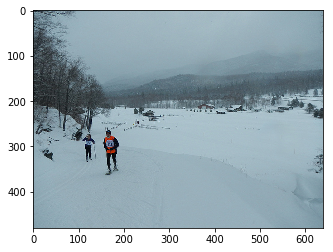

Argmax Caption:
a group of people skiing down a snow covered slope

Beam Search Caption:
a group of people riding skis down a snow covered slope

Original Captions:
Two people are walking up a snow covered hill.
A very snowy day at the ski range; a couple of skiers trudge back up the hill.
Two people out in the snow doing cross country skiing.
Two skiers are walking in the snow on a cloudy day.
Two skiers trekking through the snow on an overcast day


In [161]:
# Plot the image.
plt.imshow(load_image(image_path))
plt.show()

# Argmax Predicted Caption
argmax_caption = generate_predictions(
    topic_transfer_values_test[idx], feature_transfer_values_test[idx], model, tokenizer, max_tokens
)
print('Argmax Caption:')
print(argmax_caption)

# Beam Search Predicted Caption
beam_search_caption = beam_search_predictions(
    topic_transfer_values_test[idx], feature_transfer_values_test[idx], model, tokenizer, max_tokens, beam_width=3
)
print('\nBeam Search Caption:')
print(beam_search_caption)

# Original Captions
print('\nOriginal Captions:')
for caption in captions_test[idx]:
    print(caption)

# Obtain BLEU Score

In [106]:
def evaluate_model(topic_values, feature_values, caption_model, captions, tokenizer, max_tokens):
    actual, predicted = [], []
    captions_length = len(captions)
    
    # Initial call to print 0% progress
    print_progress_bar_counter = 0
    print_progress_bar(print_progress_bar_counter, captions_length)
    
    for idx in range(captions_length):
        # generate description
        y_pred = beam_search_predictions(
            topic_values[idx], feature_values[idx], caption_model, tokenizer, max_tokens
        )
        
        # store actual and predicted
        references = [caption.split() for caption in captions[idx]]
        actual.append(references)
        predicted.append(y_pred.split())
        
        # Update Progress Bar
        print_progress_bar_counter += 1
        print_progress_bar(print_progress_bar_counter, captions_length)

    print()
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
%%time
evaluate_model(
    topic_transfer_values_test, feature_transfer_values_test, model, captions_test, tokenizer, max_tokens
)